In [10]:
import numpy as np
import pandas as pd
import gdown
import os

from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, roc_curve, roc_auc_score, average_precision_score, ConfusionMatrixDisplay, auc
import scikitplot as skplt
import matplotlib.pyplot as plt
import tensorflow as tf

In [11]:
name_file = "TRNcod.csv"
dataset = pd.read_csv(name_file)
dataset.drop(columns=['INDEX'], inplace=True)
class_1 = dataset[dataset['IND_BOM_1_1']==1]
class_2 = dataset[dataset['IND_BOM_1_2']==1]
class_1 = class_1.sample(frac=1)
class_2 = class_2.sample(frac=1)
class_1_train, class_1_validate, class_1_test = np.split(class_1,[int(0.5*len(class_1)),int(0.75*len(class_1))])
class_2_train, class_2_validate, class_2_test = np.split(class_2,[int(0.5*len(class_2)),int(0.75*len(class_2))])  
print("Classe 1 - ","Treino:",len(class_1_train),"Validação:",len(class_1_validate),"Teste:",len(class_1_test))
print("Classe 2 - ","Treino:",len(class_2_train),"Validação:",len(class_2_validate),"Teste:",len(class_2_test))
while len(class_2_train) < len(class_1_train):
  count = (len(class_1_train)-len(class_2_train)) % len(class_2_train)
  class_2_train = pd.concat([class_2_train[:count],class_2_train])
while len(class_2_validate) < len(class_1_validate):
  count = (len(class_1_validate)-len(class_2_validate)) % len(class_2_validate)
  class_2_validate = pd.concat([class_2_validate[:count],class_2_validate])
print("Classe 1 - ","Treino:",len(class_1_train),"Validação:",len(class_1_validate),"Teste:",len(class_1_test))
print("Classe 2 - ","Treino:",len(class_2_train),"Validação:",len(class_2_validate),"Teste:",len(class_2_test))
data_train = pd.concat([class_1_train,class_2_train])
data_train = data_train.sample(frac=1)
data_validate = pd.concat([class_1_validate,class_2_validate])
data_validate = data_validate.sample(frac=1)
data_test = pd.concat([class_1_test,class_2_test])
data_test = data_test.sample(frac=1)
x_train = data_train.iloc[:,:-2]
y_train = data_train.iloc[:,-2:]
x_validate = data_validate.iloc[:,:-2]
y_validate = data_validate.iloc[:,-2:]
x_test = data_test.iloc[:,:-2]
y_test = data_test.iloc[:,-2:]
y_train2 = y_train.drop(columns=['IND_BOM_1_2'])
y_validate2 = y_validate.drop(columns=['IND_BOM_1_2'])
y_test2 = y_test.drop(columns=['IND_BOM_1_2'])

Classe 1 -  Treino: 127549 Validação: 63774 Teste: 63775
Classe 2 -  Treino: 67049 Validação: 33524 Teste: 33525
Classe 1 -  Treino: 127549 Validação: 63774 Teste: 63775
Classe 2 -  Treino: 127549 Validação: 63774 Teste: 33525


In [12]:
def my_metrics(y_true,y_pred):
  y_true = y_true['IND_BOM_1_1']
  y_pred = y_pred['IND_BOM_1_1']
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred, normalize='true')
  print(classification_report(y_true,y_pred))
  print("Erro quadrático médio: ",mean_squared_error(y_true,y_pred))
  print("Auroc:", roc_auc_score(y_true,y_pred))
  print("Precisão média: ", average_precision_score(y_true, y_pred))
  print()

@tf.function
def ks(y_true,y_pred):
    y_true = tf.reshape(y_true,(-1,))
    y_pred = tf.reshape(y_pred,(-1,))
    length = tf.shape(y_true)[0]
    t = tf.math.top_k(y_pred,k = length,sorted =False)
    y_pred_sorted = tf.gather(y_pred,t.indices)
    y_true_sorted = tf.gather(y_true,t.indices)
    cum_positive_ratio = tf.truediv(
        tf.cumsum(y_true_sorted),tf.reduce_sum(y_true_sorted))
    cum_negative_ratio = tf.truediv(
        tf.cumsum(1- y_true_sorted),tf.reduce_sum(1- y_true_sorted))
    ks_value = tf.reduce_max(tf.abs(cum_positive_ratio - cum_negative_ratio))
    return ks_value

def pred_name_columns(arr):
    result = pd.DataFrame(arr, columns = ['IND_BOM_1_1'])
    return result

In [13]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from tensorflow.keras import layers, optimizers, losses
from sklearn.neural_network import MLPClassifier
from scipy import stats

In [14]:
y_train2.describe()

,IND_BOM_1_1
count,255098.000000
mean,0.500000
std,0.500001
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [15]:
print(y_train)
print(y_train2)

        IND_BOM_1_1  IND_BOM_1_2
375127            0            1
183776            0            1
131438            1            0
352074            1            0
197319            0            1
...             ...          ...
253316            1            0
307483            1            0
113707            1            0
124399            1            0
376273            1            0

[255098 rows x 2 columns]
        IND_BOM_1_1
375127            0
183776            0
131438            1
352074            1
197319            0
...             ...
253316            1
307483            1
113707            1
124399            1
376273            1

[255098 rows x 1 columns]


C:\Users\krysa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
C:\Users\krysa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\krysa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.64      0.67      0.65     63774
           1       0.65      0.62      0.63     63774

    accuracy                           0.64    127548
   macro avg       0.64      0.64      0.64    127548
weighted avg       0.64      0.64      0.64    127548

Erro quadrático médio:  0.35849248910214193
Auroc: 0.6415075108978581
Precisão média:  0.5917800916981711



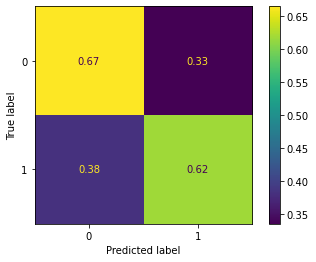

In [16]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, BaggingClassifier, VotingClassifier

rf_classifier = RandomForestClassifier(n_estimators=100,max_depth=8,min_samples_leaf=2,min_samples_split=4,max_features='sqrt')
mlp8 = MLPClassifier(hidden_layer_sizes=(50,50), solver='adam', activation='relu', learning_rate_init=0.005, max_iter=10000, 
                    early_stopping=True, n_iter_no_change=20, validation_fraction=0.1)
mlp9 = MLPClassifier(hidden_layer_sizes=(100,50,25), solver='adam', activation='relu', learning_rate_init=0.005, max_iter=10000, 
                    early_stopping=True, n_iter_no_change=20, validation_fraction=0.1)

#ensemble_classifier = BaggingClassifier(rf_classifier, mlp9).fit(x_train, y_train2['IND_BOM_1_1'])
ensemble_classifier = VotingClassifier(
            estimators=[('mlp1', mlp8), ('rf', rf_classifier), ('mlp2', mlp9)], 
            voting='soft')

mlp8.fit(x_train.to_numpy(), y_train2.to_numpy().ravel())
rf_classifier.fit(x_train.to_numpy(), y_train2.to_numpy().ravel())
mlp9.fit(x_train.to_numpy(), y_train2.to_numpy().ravel())
ensemble_classifier.fit(x_train.to_numpy(), y_train2.to_numpy().ravel())

ensemble_pred_class_val = ensemble_classifier.predict(x_validate)
y_pred_ensemble_val = pred_name_columns(ensemble_pred_class_val)
my_metrics(y_validate,y_pred_ensemble_val)

C:\Users\krysa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
C:\Users\krysa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\krysa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


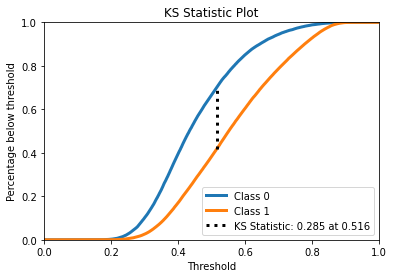

C:\Users\krysa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
C:\Users\krysa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\krysa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.48      0.67      0.56     33525
           1       0.78      0.62      0.69     63775

    accuracy                           0.63     97300
   macro avg       0.63      0.64      0.62     97300
weighted avg       0.68      0.63      0.64     97300

Erro quadrático médio:  0.3659198355601233
Auroc: 0.6426078235173234
Precisão média:  0.7321048088059887



C:\Users\krysa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
C:\Users\krysa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\krysa\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


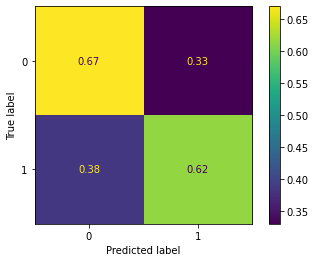

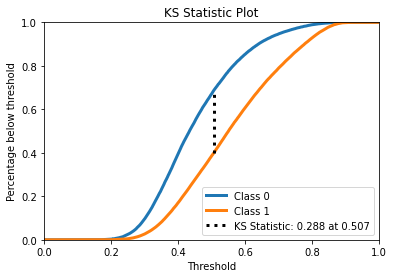

In [17]:
ensemble_prb_val = ensemble_classifier.predict_proba(x_validate)
skplt.metrics.plot_ks_statistic(y_validate['IND_BOM_1_1'], ensemble_prb_val)
plt.show()

ensemble_pred_class_test = ensemble_classifier.predict(x_test)
y_pred_ensemble_test = pred_name_columns(ensemble_pred_class_test)
my_metrics(y_test,y_pred_ensemble_test)

ensemble_prb_test = ensemble_classifier.predict_proba(x_test)
skplt.metrics.plot_ks_statistic(y_test['IND_BOM_1_1'], ensemble_prb_test)
plt.show()